# NASA Near Earth Object Analysis 2023-2024

# Introduction

This notebook provides an analysis of data on near-Earth objects (NEOs), including asteroids and comets, that came near Earth between January 1, 2023, and September 25, 2024. The dataset originates from NASA’s Jet Propulsion Laboratory (JPL) and was retrieved using the Close Approach Data API (CAD API). It contains essential details about each object's closest approach, such as the nominal distance, relative velocity, and time uncertainty.

---

# Objective

The primary objectives of this analysis are to:
- Investigate the distances of close approaches between Earth and these objects.
- Examine the velocities of the objects during their approach.
- Identify patterns in close approaches over time.
- Analyze relationships between the object size (H magnitude) and proximity to Earth.
- Apply machine learning models to predict object characteristics and outcomes based on features in the dataset.

---

# Dataset Overview

- **Date Range**: January 1, 2023 – September 25, 2024  
- **Object Types**: Asteroids and comets  
- **Source**: NASA/JPL SBDB Close Approach Data API  
- **File Path**: `/content/nasa_close_approach_2023_2024.csv`

### Fields in the Dataset:
- `des`: Object designation (unique identifier for the object)
- `orbit_id`: Orbit identification for close approach
- `jd`: Julian Date for the close approach
- `cd`: Calendar Date for the close approach
- `dist`: Nominal approach distance (AU)
- `dist_min`: Minimum approach distance (AU)
- `dist_max`: Maximum approach distance (AU)
- `v_rel`: Relative velocity (km/s)
- `v_inf`: Velocity relative to a massless object (km/s)
- `t_sigma_f`: Time uncertainty for the close approach
- `h`: Absolute magnitude of the object

---

# Analysis Plan

1. **Data Exploration**: Summarize and visualize approach distances, velocities, and time uncertainties.  
2. **Temporal Analysis**: Analyze how close approaches vary over time.  
3. **Correlation Analysis**: Study relationships between the size of the object and its approach distance or velocity.  
4. **Machine Learning Models**:
   - Apply **K-Nearest Neighbors (KNN)** to classify objects based on their features.
   - Use **XGBoost** to improve predictive performance with gradient boosting.
   - Develop an **ensemble model** using a stacked combination of **XGBoost** and **Random Forest** for robust predictions.
5. **Visualizations**: Develop plots to display the distribution of distances and velocities, along with time series trends.

---

### 🔗 **References**
- **Data Source**: [NASA/JPL SBDB Close Approach Data](https://ssd-api.jpl.nasa.gov/doc/cad.html)


# Importing Libraries

In this section, we will utilize advanced libraries to streamline data management, analysis, and visualization. We will also leverage specialized libraries for parallel processing, interactive visuals, and handling large datasets effectively.


In [1]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 47.1 MB/s eta 0:00:00


In [2]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 6.3 MB/s eta 0:00:00


In [3]:
# Core data manipulation and analysis libraries
import pandas as pd
import numpy as np

# Advanced parallel processing
import dask.dataframe as dd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # Interactive plots

# Machine learning and statistical libraries
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from hdbscan import HDBSCAN

# Time handling
import datetime as dt

# Performance monitoring
import time
import os

# Setting plot styles for better visuals
plt.style.use('ggplot')

# Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# Loading the Dataset

We will load the NASA Close Approach Data for 2023-2024 from the given CSV file and perform an initial inspections to confirm the data is ready for analysis.

In [4]:
# Kaggle dataset path
file_path = '/content/nasa_close_approach_2023_2024.csv'

# Loading the data into a Pandas DataFrame
data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to get an overview
data.head()

,des,orbit_id,jd,cd,dist,dist_min,dist_max,v_rel,v_inf,t_sigma_f,h
0,2022 YS6,6,2.459946e+06,2023-Jan-01 01:15,0.011943,0.011913,0.011973,9.719379,9.696398,< 00:01,26.86
1,2022 YR1,8,2.459946e+06,2023-Jan-01 20:45,0.041749,0.041365,0.042133,6.034629,6.024044,< 00:01,26.04
2,2022 YT3,8,2.459947e+06,2023-Jan-02 00:43,0.028460,0.028384,0.028536,6.438394,6.423836,< 00:01,25.81
3,2022 YU3,5,2.459947e+06,2023-Jan-02 05:11,0.025191,0.025017,0.025365,7.133786,7.118944,< 00:01,25.86
4,2022 YY6,4,2.459947e+06,2023-Jan-02 11:07,0.005439,0.005411,0.005467,20.269551,20.245368,< 00:01,26.15


# Exploring the Dataset

Here, we will examine the dataset's structure, including its dimensions, data types, and any missing values. This step ensures the dataset is clean and properly formatted for analysis

In [ ]:
# Checking the basic information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2554 entries, 0 to 2553
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   des        2554 non-null   object 
 1   orbit_id   2554 non-null   int64  
 2   jd         2554 non-null   float64
 3   cd         2554 non-null   object 
 4   dist       2554 non-null   float64
 5   dist_min   2554 non-null   float64
 6   dist_max   2554 non-null   float64
 7   v_rel      2554 non-null   float64
 8   v_inf      2554 non-null   float64
 9   t_sigma_f  2554 non-null   object 
 10  h          2554 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 219.6+ KB


In [ ]:
# Checking for missing values in the dataset
missing_values = data.isnull().sum()

In [ ]:
# Display missing values
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 des          0
orbit_id     0
jd           0
cd           0
dist         0
dist_min     0
dist_max     0
v_rel        0
v_inf        0
t_sigma_f    0
h            0
dtype: int64


# Descriptive Statistics

In this phase, we will compute statistics for the numerical features in the dataset. This will provide insights into data distribution and help us detect outliers or anomalies.

In [ ]:
# Generating descriptive statistics for numerical columns
data.describe()

,orbit_id,jd,dist,dist_min,dist_max,v_rel,v_inf,h
count,2554.000000,2.554000e+03,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000,2554.000000
mean,6.871574,2.460252e+06,0.021260,0.020854,0.022363,10.537411,10.481331,26.102405
std,15.821937,1.725457e+02,0.014159,0.014023,0.017751,5.136802,5.154357,1.812646
min,1.000000,2.459946e+06,0.000054,0.000054,0.000054,0.437707,0.125474,15.940000
25%,2.000000,2.460101e+06,0.008784,0.008555,0.008849,7.016223,6.963695,25.110000
50%,4.000000,2.460243e+06,0.019520,0.018903,0.019932,9.538074,9.485990,26.140000
75%,7.000000,2.460387e+06,0.032454,0.031912,0.033245,13.224340,13.192918,27.210000
max,360.000000,2.460578e+06,0.049956,0.049737,0.220768,36.372328,36.370672,32.338000


# Visualizing Key Distributions

This step involves visualizing key variables, such as nominal approach distance (dist) and relative velocity (v_rel), to observe their distributions and uncover any significant patterns in the data.

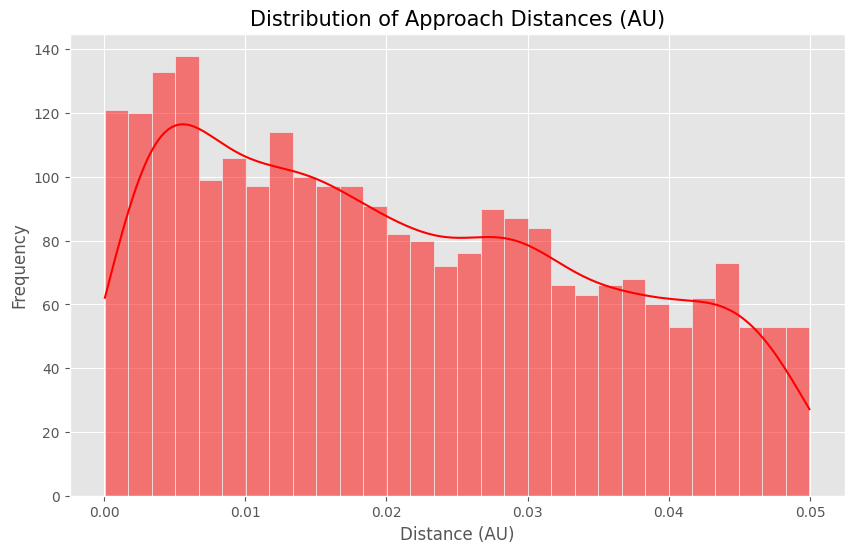

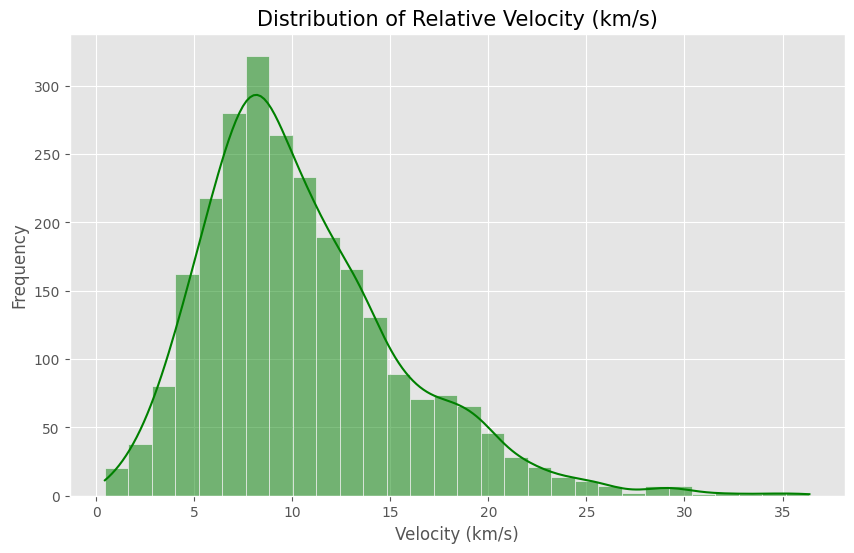

In [5]:
# Visualizing the distribution of approach distance (dist)
plt.figure(figsize=(10, 6))
sns.histplot(data['dist'], bins=30, kde=True, color='red')
plt.title('Distribution of Approach Distances (AU)', fontsize=15)
plt.xlabel('Distance (AU)')
plt.ylabel('Frequency')
plt.show()

# Visualizing the distribution of relative velocity (v_rel)
plt.figure(figsize=(10, 6))
sns.histplot(data['v_rel'], bins=30, kde=True, color='green')
plt.title('Distribution of Relative Velocity (km/s)', fontsize=15)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Frequency')
plt.show()

# Relationship Between Approach Distance and Object Size

We analyze the relationship between the approach distance (dist) and absolute magnitude (h), which reflects object size. This will help us determine if larger objects tend to approach Earth more closely.



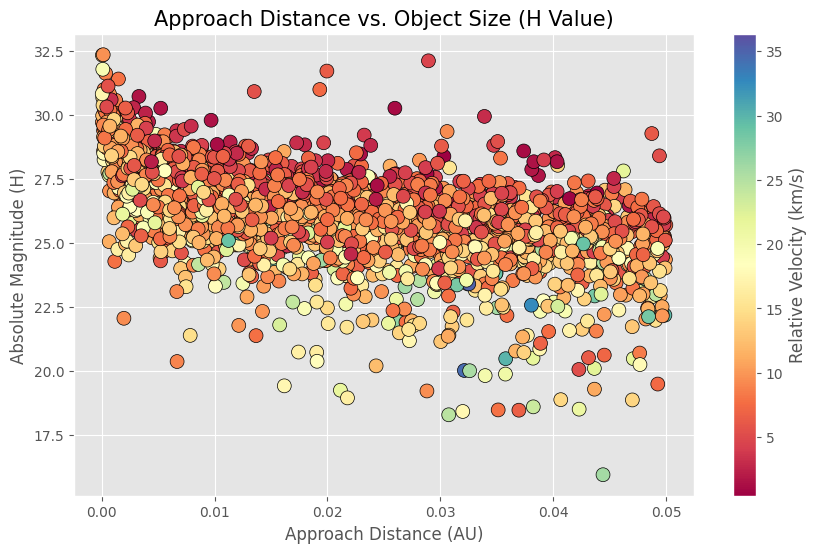

In [16]:
# Scatter plot for Approach Distance vs. Object Size (H value) with proper color mapping
plt.figure(figsize=(10, 6))

# Create scatter plot using plt.scatter for better colorbar control
sc = plt.scatter(x=data['dist'], y=data['h'], c=data['v_rel'], cmap='Spectral', s=100, edgecolor='black')

# Adding title and labels
plt.title('Approach Distance vs. Object Size (H Value)', fontsize=15)
plt.xlabel('Approach Distance (AU)')
plt.ylabel('Absolute Magnitude (H)')

# Adding the colorbar for Relative Velocity (v_rel)
cbar = plt.colorbar(sc)
cbar.set_label('Relative Velocity (km/s)')

plt.grid(True)
plt.show()

# Time Series Analysis - Close Approaches Over Time

Next, we create a time series plot to track the frequency of close approaches over time. This will enable us to identify trends, cycles, or clusters in the data.

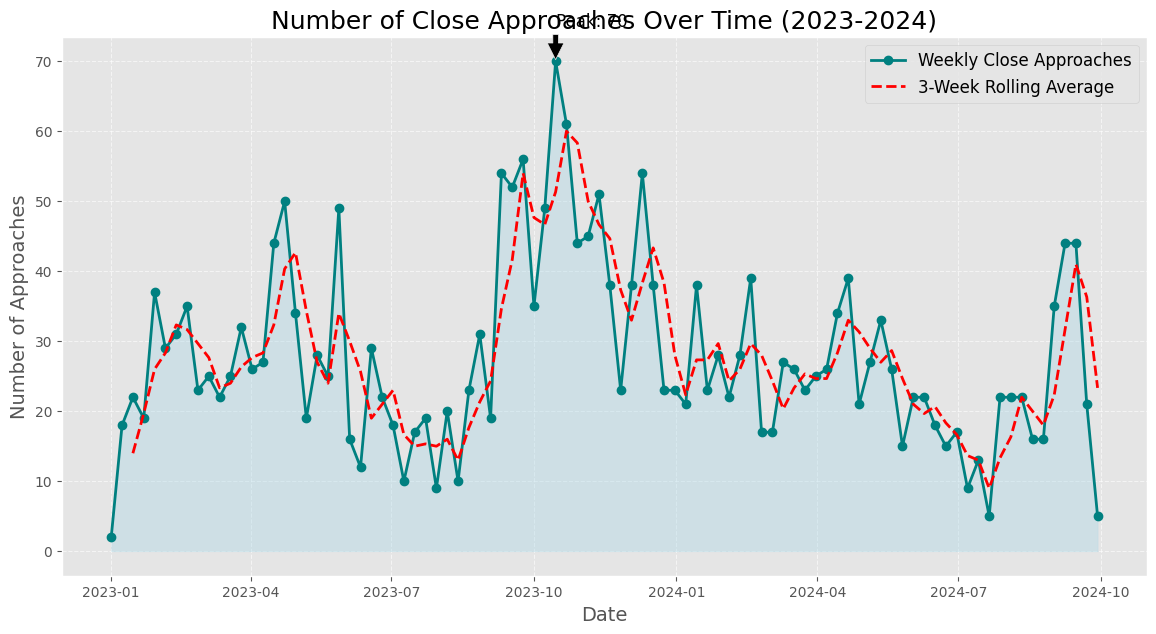

In [ ]:
# Convert 'cd' (calendar date) to datetime format
data['cd'] = pd.to_datetime(data['cd'])

# Resampling the data to a weekly count to smoothen the visualization
weekly_approaches = data['cd'].value_counts().resample('W').sum().sort_index()

# Plotting the number of close approaches over time with enhancements
plt.figure(figsize=(14, 7))

# Line plot with markers
plt.plot(weekly_approaches.index, weekly_approaches.values, linestyle='-', marker='o', color='teal', label='Weekly Close Approaches', lw=2, markersize=6)

# Filling area under the curve for better visualization
plt.fill_between(weekly_approaches.index, weekly_approaches.values, color='lightblue', alpha=0.4)

# Adding a trend line with a rolling mean (3-week window)
rolling_mean = weekly_approaches.rolling(window=3).mean()
plt.plot(weekly_approaches.index, rolling_mean, color='red', linestyle='--', lw=2, label='3-Week Rolling Average')

# Adding annotations for significant points (optional)
max_date = weekly_approaches.idxmax()
max_value = weekly_approaches.max()
plt.annotate(f'Peak: {max_value}', xy=(max_date, max_value), xytext=(max_date, max_value+5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black')

# Adding titles, labels, and a legend
plt.title('Number of Close Approaches Over Time (2023-2024)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Approaches', fontsize=14)

# Adding grid and formatting
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()

# Correlation Analysis


In this step, we will calculate the correlation matrix and represent it with a heatmap. This visualization will help uncover relationships between variables such as approach distance, velocity, and object size.

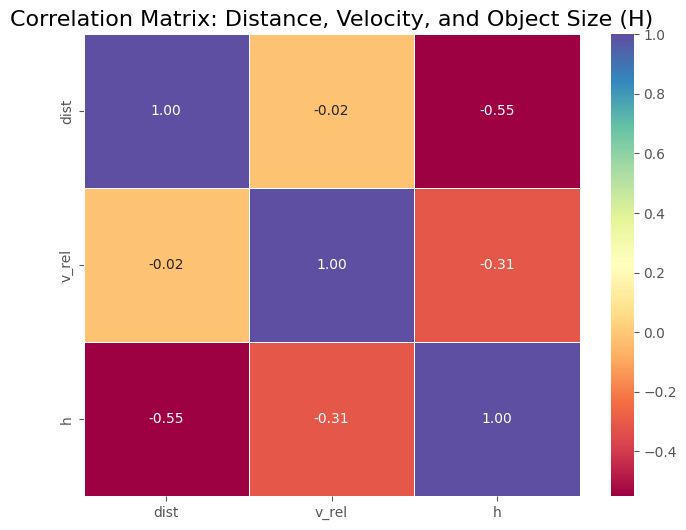

In [15]:
# Correlation matrix
correlation_matrix = data[['dist', 'v_rel', 'h']].corr()

# Plotting the heatmap for correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix: Distance, Velocity, and Object Size (H)', fontsize=16)
plt.show()

# Pairplot - Visualizing Multiple Relationships

To analyze the relationships between approach distance (`dis`), relative velocity (`v_rel`), and object size (`h`), we will use a pairplot.


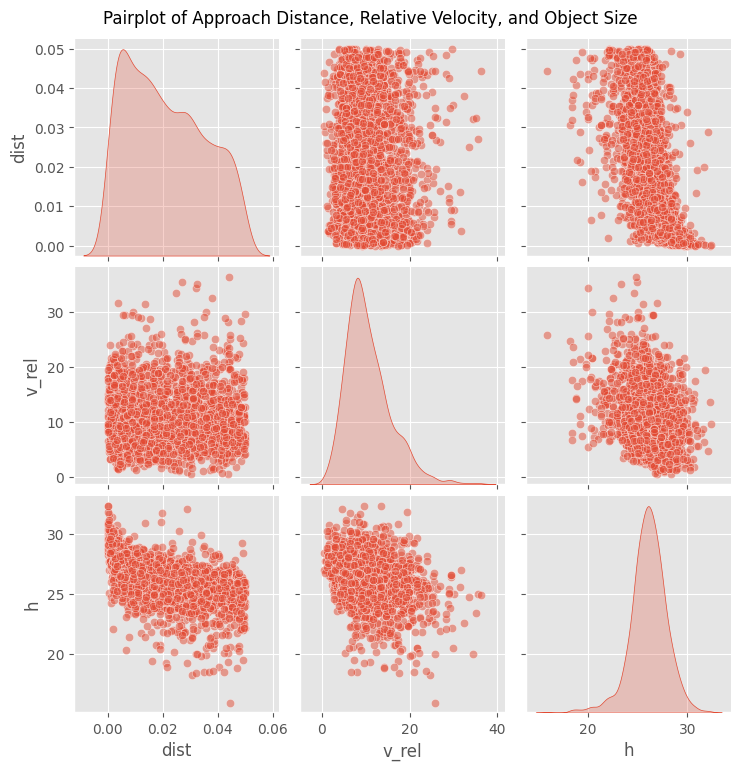

In [17]:
# Pairplot for dist, v_rel, and h
sns.pairplot(data[['dist', 'v_rel', 'h']], kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Approach Distance, Relative Velocity, and Object Size', y=1.02)
plt.show()

# 🔍 K-Means Clustering

We will use K-Means clustering to group the near-Earth objects based on their approach distance (`dist`), relative velocity (`v_rel`), and size (`h`). This will help us identify patterns or groupings in the data.


In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting the relevant features for clustering
X = data[['dist', 'v_rel', 'h']]

# Standardizing the data before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # We can adjust the number of clusters (e.g., 3 clusters)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Adding the cluster labels to the original data
print("Cluster centers:\n", kmeans.cluster_centers_)

Cluster centers:
 [[-0.79621676 -0.28807243  0.6874904 ]
 [ 0.9351697  -0.40520712 -0.42706648]
 [ 0.13937147  1.50279999 -0.86337616]]


# 3D Scatter Plot - Visualizing Clusters

Next, we will visualize the resulting clusters in a 3D space, using approach distance (dist), relative velocity (v_rel), and object size (h) as the axes.

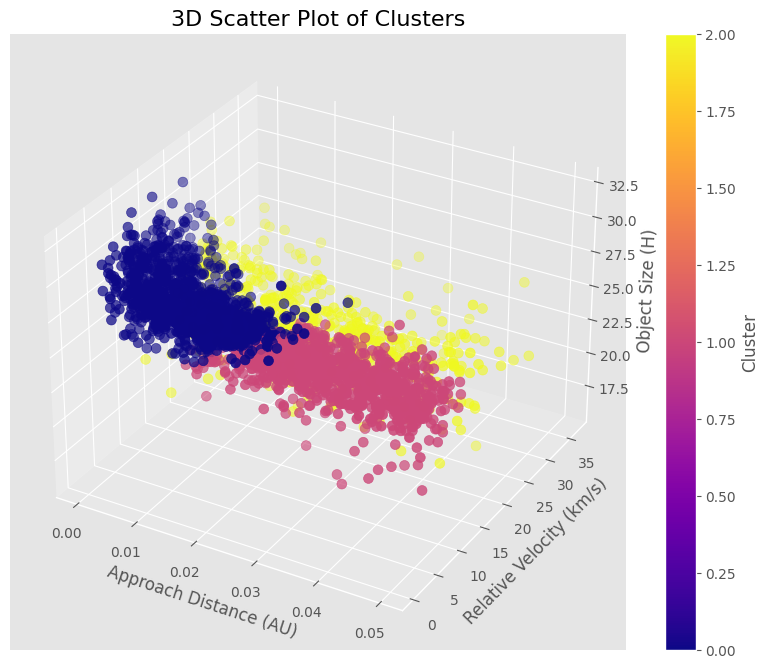

In [30]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot for visualizing clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data points in 3D with color based on cluster
scatter = ax.scatter(data['dist'], data['v_rel'], data['h'], c=data['cluster'], cmap='plasma', s=50)

# Adding labels and title
ax.set_xlabel('Approach Distance (AU)')
ax.set_ylabel('Relative Velocity (km/s)')
ax.set_zlabel('Object Size (H)')
ax.set_title('3D Scatter Plot of Clusters', fontsize=16)

# Adding a color bar to show cluster colors
plt.colorbar(scatter, label='Cluster')

plt.show()

# Cluster Profiling


We will calculate the mean values of key variables such as approach distance, velocity, and size for each cluster to gain insights into the characteristics of each group.

In [24]:
# Select only numeric columns for calculating mean
numeric_columns = ['dist', 'v_rel', 'h']  # These are the columns we are interested in

# Grouping data by clusters and computing the mean for numeric columns
cluster_profile = data.groupby('cluster')[numeric_columns].mean()

# Adding count of objects in each cluster
cluster_profile['count'] = data['cluster'].value_counts()

# Displaying the cluster profile
cluster_profile

,dist,v_rel,h,count
cluster,,,,
0,0.009968,9.076484,27.348084,1164
1,0.034488,8.453526,25.330034,921
2,0.023311,18.255486,24.527529,469


# Evaluating Clustering with Silhouette Score


We will now compute the Silhouette Score to evaluate the quality of clustering. This metric ranges from -1 to 1, with higher values indicating more distinct and well-defined clusters.

In [25]:
from sklearn.metrics import silhouette_score

# Calculating the silhouette score
silhouette_avg = silhouette_score(X_scaled, data['cluster'])
print(f'Silhouette Score for the clustering: {silhouette_avg:.3f}')

Silhouette Score for the clustering: 0.332


# Visualizing Cluster Profiles

Bar plots will be created to visualize the average approach distance, velocity, and size for each cluster, providing a clear comparison of their characteristics.

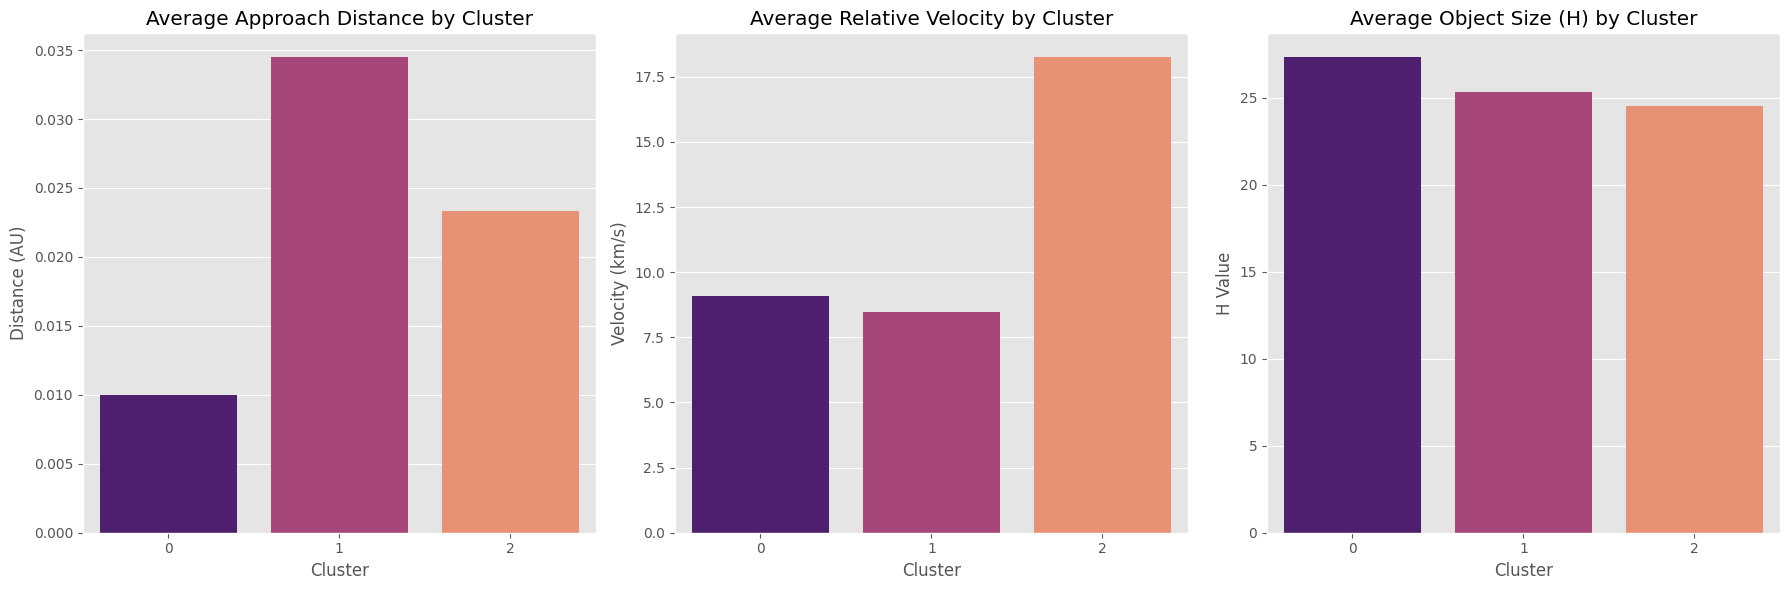

In [26]:
# Visualizing the cluster profile using bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Approach Distance by Cluster
sns.barplot(x=cluster_profile.index, y=cluster_profile['dist'], ax=axes[0], palette='magma')
axes[0].set_title('Average Approach Distance by Cluster')
axes[0].set_ylabel('Distance (AU)')
axes[0].set_xlabel('Cluster')

# Relative Velocity by Cluster
sns.barplot(x=cluster_profile.index, y=cluster_profile['v_rel'], ax=axes[1], palette='magma')
axes[1].set_title('Average Relative Velocity by Cluster')
axes[1].set_ylabel('Velocity (km/s)')
axes[1].set_xlabel('Cluster')

# Object Size by Cluster (H)
sns.barplot(x=cluster_profile.index, y=cluster_profile['h'], ax=axes[2], palette='magma')
axes[2].set_title('Average Object Size (H) by Cluster')
axes[2].set_ylabel('H Value')
axes[2].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

# Cluster Summary Table

A summary of the average approach distance, velocity, and size (h) for each cluster will be presented to consolidate the analysis.

In [27]:
# Using Pandas to format and display the cluster profile table
cluster_summary = cluster_profile[['dist', 'v_rel', 'h', 'count']].round(2)
print(cluster_summary)

         dist  v_rel      h  count
cluster                           
0        0.01   9.08  27.35   1164
1        0.03   8.45  25.33    921
2        0.02  18.26  24.53    469


# Predictive Modeling with KNN

We will construct a KNN model to predict the cluster of a near-Earth object based on its approach distance (dist), velocity (v_rel), and size (h).

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features and target variable
X = data[['dist', 'v_rel', 'h']]
y = data['cluster']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, y_train)

# Predict the cluster for the test set
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9726205997392438

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       362
           1       0.98      0.96      0.97       280
           2       0.95      0.98      0.96       125

    accuracy                           0.97       767
   macro avg       0.97      0.97      0.97       767
weighted avg       0.97      0.97      0.97       767



# Risk Analysis - Identifying Potential Threats

We will identify the top objects with the smallest approach distance and the largest size (`h`), as they may pose the highest potential risk to Earth.

In [29]:
# Identify the objects with the smallest approach distance and largest size (high risk potential)
potential_risks = data[(data['dist'] < 0.01) & (data['h'] < 20)].sort_values(by='dist', ascending=True)

# Display the top 10 potentially risky objects based on approach distance and size
top_risks = potential_risks[['des', 'dist', 'v_rel', 'h']].head(10)

# Show the top 10 risks
print(top_risks)

Empty DataFrame
Columns: [des, dist, v_rel, h]
Index: []


# Interactive Visualizations with Plotly

We will create an interactive 3D scatter plot using Plotly to allow for exploration of approach distance, velocity, and size in 3D space.

In [ ]:
# Create an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(data, x='dist', y='v_rel', z='h', color='cluster', hover_name='des',
                    title='Interactive 3D Scatter Plot of Near-Earth Objects',
                    labels={'dist': 'Approach Distance (AU)', 'v_rel': 'Relative Velocity (km/s)', 'h': 'Object Size (H)'})

# Show the plot
fig.show()

# HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

Here we use an alternative to K Means. This will be used as a different method to explore the inherent structure in the data, identify meaningful groupings, and manage noise.


In [ ]:
# Preprocessing for clustering and classification
features = ["dist", "dist_min", "dist_max", "v_rel", "v_inf", "h"]
X = data[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# HDBSCAN for clustering
hdbscan = HDBSCAN(min_cluster_size=5, min_samples=5, cluster_selection_epsilon=0.5)
hdbscan_labels = hdbscan.fit_predict(X_scaled)
data["cluster"] = hdbscan_labels

print("HDBSCAN Clustering Results:")
print(data["cluster"].value_counts())

HDBSCAN Clustering Results:
cluster
 1    2285
-1     256
 2       7
 0       6
Name: count, dtype: int64


In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data["orbit_id"])

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

# Handle class imbalance by combining SMOTE and Random Oversampling
smote = SMOTE(random_state=42, k_neighbors=1)
ros = RandomOverSampler(random_state=42)

# Apply SMOTE for classes with enough samples and ROS for others
X_resampled, y_resampled = ros.fit_resample(X, y_encoded)

# Check the class distribution after resampling
print("Class distribution after combined oversampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution after combined oversampling:
5     440
72    440
40    440
75    440
44    440
     ... 
61    440
34    440
15    440
65    440
49    440
Name: count, Length: 77, dtype: int64


# XGBoost

We also use XGBoost for classification due to its robustness, flexibility, and ability to handle imbalanced datasets effectively. Combined with HDBSCAN for preprocessing, it enables us to build a strong model with high interpretability and accuracy.

In [ ]:
# Train-Test split with resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [ ]:
# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [ ]:
# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nXGBoost Classification Results:")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)


XGBoost Classification Results:
Accuracy: 0.9602

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.45      0.47        88
           1       0.33      0.27      0.30        88
           2       0.46      0.35      0.40        88
           3       0.51      0.50      0.50        88
           4       0.60      0.64      0.62        88
           5       0.77      0.82      0.80        88
           6       0.92      0.97      0.94        88
           7       0.88      0.95      0.91        88
           8       0.96      0.98      0.97        88
           9       0.94      1.00      0.97        88
          10       0.98      1.00      0.99        88
          11       0.97      1.00      0.98        88
          12       1.00      1.00      1.00        88
          13       0.99      1.00      0.99        88
          14       0.98      1.00      0.99        88
          15       0.99      1.00      0.99        88
       

## Balance Classes and Re-Encode Labels

In [ ]:
# Step 1: Remove rare classes (threshold = 2 samples)
class_counts = pd.Series(y_encoded).value_counts()
valid_classes = class_counts[class_counts >= 2].index
mask = np.isin(y_encoded, valid_classes)
X_filtered = X[mask]
y_filtered = y_encoded[mask]



In [ ]:

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42, k_neighbors=1)
X_balanced, y_balanced = smote.fit_resample(X_filtered, y_filtered)

In [ ]:
# Re-encode labels
label_encoder = LabelEncoder()
y_balanced = label_encoder.fit_transform(y_balanced)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Define stacking model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=4, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(stacking_model, X_balanced, y_balanced, cv=skf, scoring="accuracy")

# Output cross-validation results
print(f"Stacking Cross-Validation Accuracy: {cv_scores.mean():.4f}")

Stacking Cross-Validation Accuracy: 0.8733


In [ ]:
# Split into train-test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Train the stacking model on the training set
stacking_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = stacking_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.8809

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.39      0.36        74
           1       0.20      0.17      0.18        71
           2       0.33      0.18      0.24        87
           3       0.43      0.33      0.38        93
           4       0.47      0.46      0.47        87
           5       0.68      0.69      0.68        91
           6       0.63      0.70      0.67        94
           7       0.65      0.70      0.67        76
           8       0.76      0.64      0.69        92
           9       0.76      0.85      0.80        99
          10       0.80      0.87      0.83        86
          11       0.91      0.92      0.91        87
          12       0.97      0.92      0.94        90
          13       0.92      0.96      0.94        92
          14       0.92      0.96      0.94       105
          15       0.95      0.95      0.95        77
          16       0.95      0.97 

## Feature importance from XGBoost

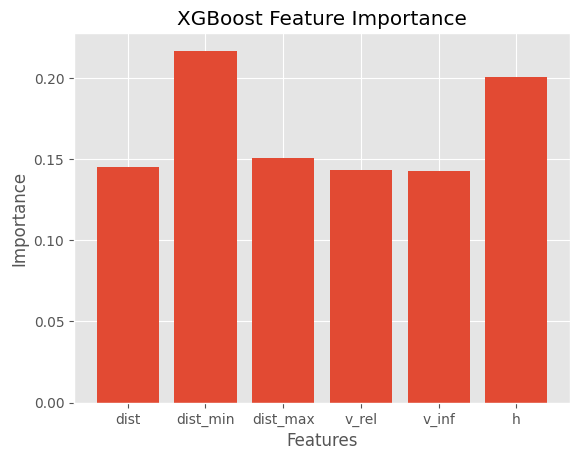

In [ ]:

xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=4, random_state=42)
xgb_model.fit(X_balanced, y_balanced)

import matplotlib.pyplot as plt
plt.bar(features, xgb_model.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

# Reduce to 3D for visualization
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_balanced)

# Create a DataFrame for Plotly
df_3d = pd.DataFrame(X_3d, columns=['PCA1', 'PCA2', 'PCA3'])
df_3d['Class'] = y_balanced

# Plot 3D scatter with Plotly
fig = px.scatter_3d(
    df_3d, x='PCA1', y='PCA2', z='PCA3',
    color='Class', title="3D Visualization of Classes",
    labels={'Class': 'True Class'},
    opacity=0.7
)
fig.show()

In [ ]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Convert classes to list (if they are not already)
classes = list(label_encoder.classes_)

# Create the heatmap
fig = ff.create_annotated_heatmap(
    z=cm,
    x=classes,
    y=classes,
    colorscale='Viridis',
    showscale=True,
    annotation_text=cm.astype(str),
    hoverinfo="z"  # Adds hover info for matrix values
)

# Update layout for clarity
fig.update_layout(
    title=dict(
        text="Interactive Confusion Matrix",
        x=0.5,  # Center the title
        font=dict(size=20)  # Increase font size
    ),
    xaxis=dict(
        title="Predicted Labels",
        title_font=dict(size=16),
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title="True Labels",
        title_font=dict(size=16),
        tickfont=dict(size=12)
    ),
    autosize=False,  # Enable manual size adjustment
    width=900,  # Set custom width
    height=900  # Set custom height
)

# Display the figure
fig.show()
